In [1]:
!tar xf ./dtd/dtd-r1.0.1.tar.gz

In [1]:
import pickle
import os
import cv2 as cv
from random import randrange
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imutils import rotate_bound as rotate
import random

In [ ]:
dtd_dir="./dtd/images/"
bg_images=[]
for subdir in os.listdir(dtd_dir):
    for f in os.listdir(dtd_dir+subdir):
        bg_images.append(cv.imread(dtd_dir+subdir+"/"+f, cv.IMREAD_COLOR))

print("Nb of images loaded :",len(bg_images))
with open(dtd_dir + "bg_pickle.pk", "wb") as f:
    pickle.dump(bg_images, f)

Nb of images loaded : 5641


In [12]:
#resize bgimage at 900x1600
#resize cards at standard dimension before pasting (430x295)
#choose 1 of 4 arrangements: single card, four cards, nine cards, 2 to 9 randomly placed cards
    # take the supposed centers (fixed for the first three, random for the second) of the card (coordinate in the image) and compute the supposed BB
#rotate, scale, translate, glare each card. random skew all cards in the same image 
    # less aggressive for the second and third arrangement
    # modify the BB accordingly
    # compute then BB from keypoints
# multiply, simplexnoisealpha, additive gaussian, dropout on the image
bg_image_size = (1600, 900) # w x h
card_size = (295, 430)
single_card_arrangement = [(800,450)] # coordinates are (x,y)
four_cards_arrangement = [(643, 230), (957, 230), (643, 670), (957, 670)]
random_arrangement = [(randrange(1600), randrange(900)) for i in range(randrange(2, 9))]


In [60]:
def rotate_image(image, angle):
    """Rotate the image counterclockwise.
    Rotate the image such that the rotated image is enclosed inside the
    tightest rectangle. The area not occupied by the pixels of the original
    image is colored black.
    Parameters
    ----------
    image : numpy.ndarray
        numpy image
    angle : float
        angle by which the image is to be rotated. Positive angle is
        counterclockwise.
    Returns
    -------
    numpy.ndarray
        Rotated Image
    """
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv.warpAffine(image, M, (nW, nH), cv.INTER_LANCZOS4)

    # image = cv2.resize(image, (w,h))

    return image

# scaling c'è resize
# translation, modifico i centri
# glare???
# skew??
# multiply, simplexnoisealpha, additive gaussian, dropout on the image???

In [63]:
def paste(subimg, bgimg, sub_on_bg_center_coord):
     # first we compute the hypotetical top left corner of the image to be pasted on the bg
     # we use coordinates unbounded from image dimension
     top_left_img_x = sub_on_bg_center_coord[0] - int(subimg.shape[1]//2)
     top_left_img_y = sub_on_bg_center_coord[1] - int(subimg.shape[0]//2)

     # then the bottom right
     bottom_right_img_x = top_left_img_x + subimg.shape[1]
     bottom_right_img_y = top_left_img_y + subimg.shape[0]

     # then we compute the top left coordinate within the subimg
     top_left_sub_x = abs(min(0, top_left_img_x))
     top_left_sub_y = abs(min(0, top_left_img_y))

     # so that we can normalize (bound to 0,0 origin) the bgimage coordinates
     top_left_img_x = max(0, top_left_img_x)
     top_left_img_y = max(0, top_left_img_y)

     # lastly we compute the bottom right coordinate within the subimg
     bottom_right_sub_x = subimg.shape[1] - max(0, bottom_right_img_x - bgimg.shape[1])
     bottom_right_sub_y = subimg.shape[0] - max(0, bottom_right_img_y - bgimg.shape[0])

     # and normalize the bottom right coordinate of the bgimg
     bottom_right_img_x = min(bottom_right_img_x, bgimg.shape[1])
     bottom_right_img_y = min(bottom_right_img_y, bgimg.shape[0])

     pasted_img = bgimg.copy()
     pasted_img[top_left_img_y:bottom_right_img_y, 
                top_left_img_x:bottom_right_img_x, :] = np.where(subimg[top_left_sub_y:bottom_right_sub_y,top_left_sub_x:bottom_right_sub_x, :],
                                                                   subimg[top_left_sub_y:bottom_right_sub_y,top_left_sub_x:bottom_right_sub_x, :],
                                                                   bgimg[top_left_img_y:bottom_right_img_y, 
                                                                         top_left_img_x:bottom_right_img_x, :])
     return pasted_img

def generate_image(background_img, card_list, arrangement, per_card_transform, image_transform):
     card_bunch = np.zeros(background_img.shape, dtype=np.uint8)
     card_bbs = []
     for c in range(len(card_list)):
          card_image = card_list[c]
          # apply scaling
          scaled_card = cv.resize(card_image, (int(card_image.shape[1]*per_card_transform[c]["scale"]),
                                                int(card_image.shape[0]*per_card_transform[c]["scale"])))
          # apply glare
          glared_card = per_card_transform[c]["glare"].augment_image(scaled_card)
          # rotate
          rotated_card = rotate(glared_card, per_card_transform[c]["rot_angle"])
          # TODO: CONTROLLARE OVERLAPPING
          #bb = [arrangement[c][0], arrangement[c][1], rotated_card.shape[0], rotated_card.shape[1], per_card_transform[c]["rot_angle"]]
          #card_bbs.append(bb)
          card_bunch = paste(rotated_card, card_bunch, arrangement[c])


     # TODO: CONTROLLARE OVERLAPPING
     #card_bunch = cv.GaussianBlur(card_bunch, (5, 5), 0)
     # skew
     card_bunch = cv.cvtColor()
     final_image = np.where(card_bunch, card_bunch, background_img)
     return final_image



True

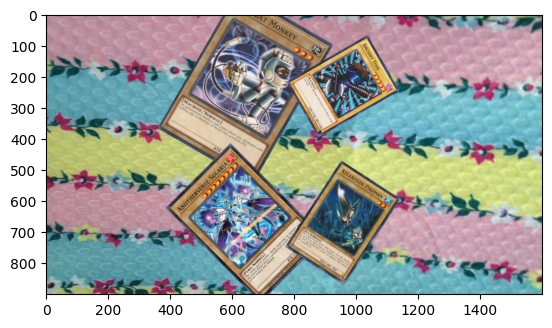

In [64]:
card_list = []
i=0
for c in os.listdir("./sample_images/normal/"):
    card_list.append(cv.imread("./sample_images/normal/" + c, cv.IMREAD_COLOR))
    i =i + 1 
    if i == 4:
        break

card_list = [cv.resize(c, card_size) for c in card_list]
bg = cv.imread("./dtd/images/bumpy/bumpy_0080.jpg", cv.IMREAD_COLOR)
bg = cv.resize(bg, bg_image_size)

g =iaa.Sequential([
                    iaa.BlendAlphaSimplexNoise(foreground=iaa.Add(random.randrange(128)), size_px_max=[1, 3],
                                          upscale_method="cubic"),  # Lighting
                ])
per_card_transform = [{"scale" :1.2,"rot_angle" : 30, "glare": g},
                      {"scale" :0.7,"rot_angle" : 60, "glare": g},
                      {"scale" :1.0,"rot_angle" : -45, "glare": g},
                      {"scale" :0.77,"rot_angle" : 33, "glare": g}, ]
output = generate_image(bg, card_list, four_cards_arrangement, per_card_transform, None)

plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
cv.imwrite("test.jpg", output)

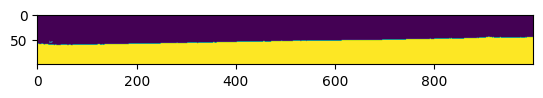

In [ ]:
potential_mask = cv.imread("mask.tiff")
border_crop = potential_mask[2100:2200,500:1500]
border_crop =  cv.GaussianBlur(border_crop, (3, 3), 0)
border_crop = cv.cvtColor(border_crop, cv.COLOR_BGR2HSV)
lower = (85,120,120)
higher = (150, 255, 255)
mask = cv.inRange(border_crop, lower, higher)
imask = mask < 1.
green = np.zeros_like(border_crop, np.uint8)
green[imask] = border_crop[imask]
plt.imshow(mask)

True

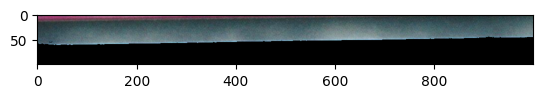

In [72]:
plt.imshow(cv.cvtColor(green, cv.COLOR_HSV2RGB))
cv.imwrite("crop.png", cv.cvtColor(green, cv.COLOR_HSV2RGB))

In [ ]:
cnt 